In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants and parameters
M_Pl = 1.22e19  # Planck mass in GeV
M_X = 1e16      # Mass of X boson in GeV
g_GUT = 0.5     # GUT coupling constant

In [2]:

# =====================================================================
# Part 1: Derive decay widths for toy SU(5) GUT
# =====================================================================

def toy_su5_gut_model():
    """Define a simple toy SU(5) GUT model with X and Y bosons"""
    
    # SU(5) gauge coupling
    g = g_GUT
    
    # Masses (in GeV)
    M_X = 1e16  # X boson
    M_Y = M_X   # Y boson (typically the same mass)
    
    # Base decay width formula: Γ ~ g²M/(8π)
    base_width_X = (g**2 * M_X) / (8 * np.pi)
    base_width_Y = (g**2 * M_Y) / (8 * np.pi)
    
    # In a typical SU(5) GUT, X and Y bosons can decay to:
    # X → d + l  (down-type quark + lepton)
    # X → u̅ + l̅  (anti-up-type quark + antilepton)
    # Y → u + l  (up-type quark + lepton)
    # Y → d̅ + l̅  (anti-down-type quark + antilepton)
    
    # CP violation can arise from interference with loop diagrams
    # Calculate a toy CP asymmetry
    
    # Simplified loop factor (in a real calculation, this would come from detailed loop calculations)
    loop_factor = 1/(4*np.pi)
    
    # Phase from the complex Yukawa couplings or mixing matrices
    complex_phase = 0.1  # Example value
    
    # Calculate CP asymmetry for X boson decays
    epsilon_X = loop_factor * complex_phase
    
    # Decay channels and rates
    decay_channels = {
        "X → dl": base_width_X * 0.5 * (1 + epsilon_X),  # X to down-quark + lepton
        "X → d̅l̅": base_width_X * 0.5 * (1 - epsilon_X),  # X to anti-down-quark + anti-lepton
        "Y → ul": base_width_Y * 0.5,                    # Y to up-quark + lepton
        "Y → d̅l̅": base_width_Y * 0.5                     # Y to anti-down-quark + anti-lepton
    }
    
    # Total decay widths
    total_width_X = decay_channels["X → dl"] + decay_channels["X → d̅l̅"]
    total_width_Y = decay_channels["Y → ul"] + decay_channels["Y → d̅l̅"]
    
    # Calculate the observable CP asymmetry
    cp_asymmetry = (decay_channels["X → dl"] - decay_channels["X → d̅l̅"]) / total_width_X
    
    return {
        "decay_channels": decay_channels,
        "total_width_X": total_width_X,
        "total_width_Y": total_width_Y,
        "cp_asymmetry": cp_asymmetry,
        "M_X": M_X,
        "g_GUT": g
    }

In [3]:

# =====================================================================
# Part 2: Solve Boltzmann equations and plot baryon yield
# =====================================================================

# Hubble parameter as a function of temperature
def H(T):
    g_star = 106.75  # Effective relativistic degrees of freedom
    return np.sqrt(g_star/90) * T**2 / M_Pl

# Equilibrium number density for X bosons
def n_X_eq(T, M_X):
    # Non-relativistic limit (Maxwell-Boltzmann)
    if T < M_X/100:  # Very low density at low T
        return 1e-50
    else:
        prefactor = (M_X*T/(2*np.pi))**(3/2)
        boltzmann = np.exp(-M_X/T)
        return prefactor * boltzmann

# Entropy density
def s(T):
    g_star_s = 106.75  # Effective entropic degrees of freedom
    return (2*np.pi**2/45) * g_star_s * T**3

# Boltzmann equations in terms of x = M_X/T and yields Y = n/s
def boltzmann_eqs(x, Y, params):
    """
    Y[0]: Y_X = n_X/s
    Y[1]: Y_B = n_B/s
    
    params: (Gamma_X, epsilon, M_X)
    """
    Gamma_X, epsilon, M_X = params
    
    # Temperature
    T = M_X/x
    
    # Current yields
    Y_X, Y_B = Y
    
    # Equilibrium yield
    Y_X_eq = n_X_eq(T, M_X) / s(T)
    
    # z = Gamma_X/H
    H_T = H(T)
    z = Gamma_X / H_T
    
    # dY_X/dx = -z * (Y_X - Y_X_eq) / x
    dY_X_dx = -z * (Y_X - Y_X_eq) / x
    
    # dY_B/dx = epsilon * z * (Y_X - Y_X_eq) / x
    dY_B_dx = epsilon * z * (Y_X - Y_X_eq) / x
    
    return [dY_X_dx, dY_B_dx]

# Solve the Boltzmann equations
def solve_boltzmann_evolution(Gamma_X, epsilon, M_X):
    # Range of x = M_X/T
    x_initial = 0.1   # T = 10*M_X
    x_final = 100     # T = M_X/100
    
    # Initial conditions
    Y_X_initial = n_X_eq(M_X/x_initial, M_X) / s(M_X/x_initial)  # Start in thermal equilibrium
    Y_B_initial = 0   # No initial baryon asymmetry
    
    # Parameters for the ODE solver
    params = (Gamma_X, epsilon, M_X)
    
    # x points (logarithmically spaced)
    x_span = (x_initial, x_final)
    x_eval = np.logspace(np.log10(x_initial), np.log10(x_final), 1000)
    
    # Solve the equations
    solution = solve_ivp(
        lambda x, Y: boltzmann_eqs(x, Y, params), 
        x_span, 
        [Y_X_initial, Y_B_initial], 
        t_eval=x_eval, 
        method='LSODA',
        rtol=1e-8,
        atol=1e-10
    )
    
    # Extract results
    x_values = solution.t
    Y_X_values = solution.y[0]
    Y_B_values = solution.y[1]
    T_values = M_X / x_values
    
    return x_values, T_values, Y_X_values, Y_B_values

Decay widths in the toy SU(5) GUT model:
X → dl: 5.01e+13 GeV
X → d̅l̅: 4.93e+13 GeV
Y → ul: 4.97e+13 GeV
Y → d̅l̅: 4.97e+13 GeV
Total X boson decay width: 9.95e+13 GeV
Total Y boson decay width: 9.95e+13 GeV
CP asymmetry ε: 7.96e-03
Final baryon yield (Y_B = n_B/s): 3.09e-07
Observed baryon yield: ~6e-10


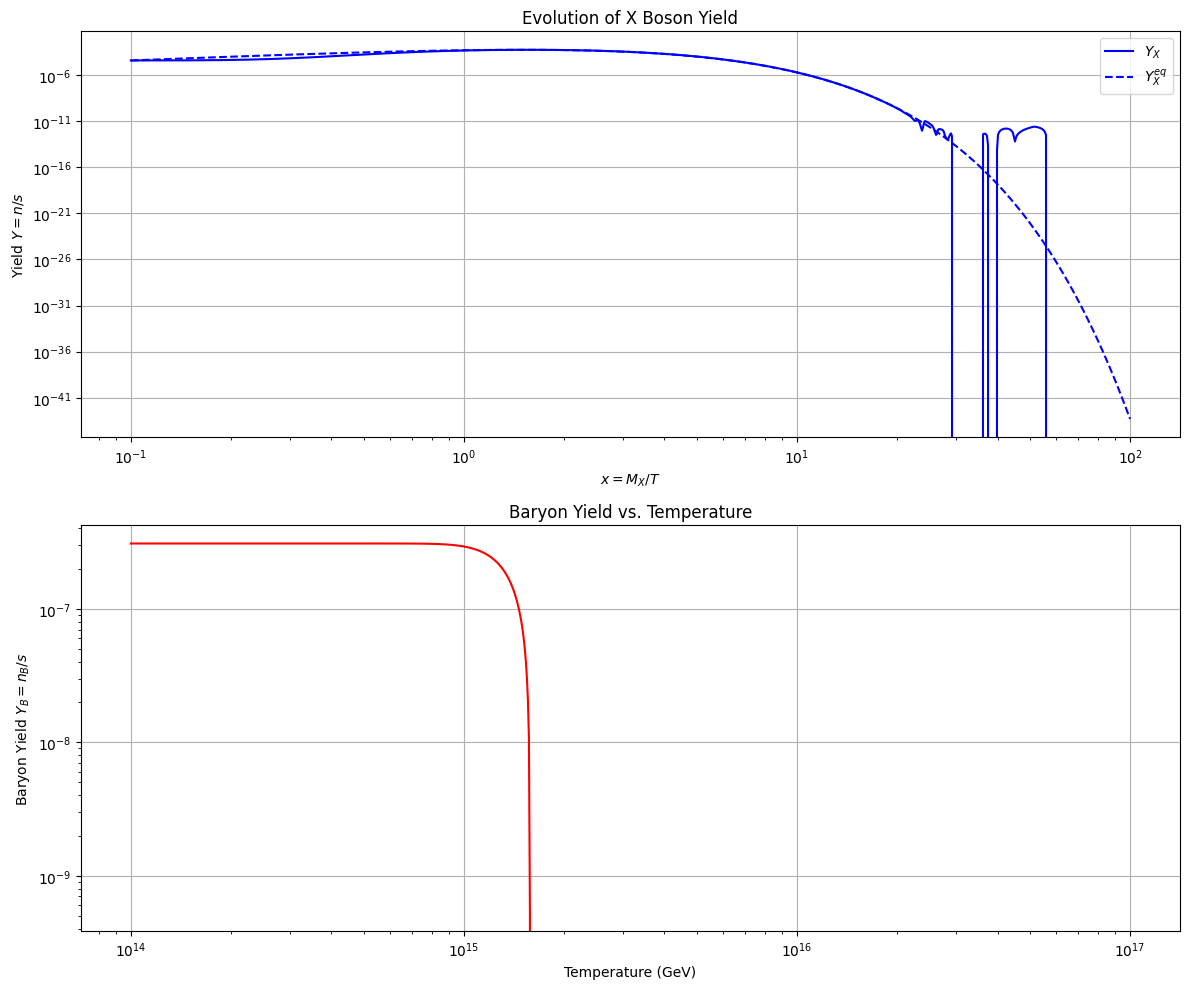

In [4]:

# =====================================================================
# Main execution
# =====================================================================

def main():
    # Part 1: Derive decay widths for toy SU(5) GUT
    gut_model = toy_su5_gut_model()
    
    print("Decay widths in the toy SU(5) GUT model:")
    for channel, width in gut_model["decay_channels"].items():
        print(f"{channel}: {width:.2e} GeV")
    
    print(f"Total X boson decay width: {gut_model['total_width_X']:.2e} GeV")
    print(f"Total Y boson decay width: {gut_model['total_width_Y']:.2e} GeV")
    print(f"CP asymmetry ε: {gut_model['cp_asymmetry']:.2e}")
    
    # Part 2: Solve Boltzmann equations and plot baryon yield
    Gamma_X = gut_model["total_width_X"]
    epsilon = gut_model["cp_asymmetry"]
    M_X = gut_model["M_X"]
    
    x_values, T_values, Y_X_values, Y_B_values = solve_boltzmann_evolution(Gamma_X, epsilon, M_X)
    
    # Calculate equilibrium yields for comparison
    Y_X_eq_values = np.array([n_X_eq(T, M_X) / s(T) for T in T_values])
    
    # Plotting
    plt.figure(figsize=(12, 10))
    
    # Plot 1: X boson yield
    plt.subplot(2, 1, 1)
    plt.loglog(x_values, Y_X_values, 'b-', label='$Y_X$')
    plt.loglog(x_values, Y_X_eq_values, 'b--', label='$Y_X^{eq}$')
    plt.xlabel('$x = M_X/T$')
    plt.ylabel('Yield $Y = n/s$')
    plt.title('Evolution of X Boson Yield')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Baryon yield vs temperature
    plt.subplot(2, 1, 2)
    plt.loglog(T_values, Y_B_values, 'r-')
    plt.xlabel('Temperature (GeV)')
    plt.ylabel('Baryon Yield $Y_B = n_B/s$')
    plt.title('Baryon Yield vs. Temperature')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('baryogenesis.png')
    
    # Print final baryon yield
    print(f"Final baryon yield (Y_B = n_B/s): {Y_B_values[-1]:.2e}")
    print(f"Observed baryon yield: ~6e-10")

if __name__ == "__main__":
    main()